In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# Author: lavinigam@ sjangbahadur@

# Text Summarization of Large Documents


<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/language/examples/document-summarization/summarization_large_documents.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/examples/document-summarization/summarization_large_documents.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/language/examples/document-summarization/summarization_large_documents.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

Text summarization is the process of creating a shorter version of a text document while still preserving the most important information. This can be useful for a variety of purposes, such as quickly skimming a long document, getting the gist of an article, or sharing a summary with others.

Although summarizing a short paragraph is a non-trivial task, there are a few challenges to overcome if you want to summarize a large document, such as a PDF file with multiple pages. In this notebook, you will go through a few examples of how you can use generative models to summarize large documents.

### Objective

In this tutorial, you will learn how to use generative models to summarize information from large documents (more than 30 pages) by working through the following methods:

- Bucketed Map Reduce

### Costs

This tutorial uses billable components of Google Cloud:
- Vertex AI Generative AI Studio

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [Generative AI pricing](https://cloud.google.com/vertex-ai/pricing#generative_ai_models), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

### Install Vertex AI SDK, other packages and their dependencies

In [ ]:
!pip install google-cloud-aiplatform PyPDF2 ratelimit backoff --upgrade --quiet --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 110.0 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


**Colab only**: Uncomment the following cell to restart the kernel. For Vertex AI Workbench you can restart the terminal using the button on top.

In [ ]:
# # Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticating your notebook environment
* If you are using **Colab** to run this notebook, uncomment the cell below and continue.
* If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [ ]:
from google.colab import auth
auth.authenticate_user()

### Import libraries

**Colab only:** Uncomment the following cell to initialize the Vertex AI SDK. For Vertex AI Workbench, you don't need to run this.

In [ ]:
import vertexai

PROJECT_ID = ""  # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location="us-central1")

In [ ]:
import re
import urllib
import warnings
from pathlib import Path

import backoff
import pandas as pd
import PyPDF2
import ratelimit
from google.api_core import exceptions
from tqdm import tqdm
from vertexai.preview.language_models import TextGenerationModel

warnings.filterwarnings("ignore")

### Import models

Here you load the pre-trained text generation model called `text-bison@001`.


In [ ]:
generation_model = TextGenerationModel.from_pretrained("text-bison@001")

### Preparing data files

To begin, you will need to download a pdf file for the summarizing tasks below.

Here you will take a peak at a few pages of the downloaded pdf file

In [ ]:
# Read the PDF file and create a list of pages
reader = PyPDF2.PdfReader("<UPLOAD YOUR PDF or LINK YOUR PDF PATH>")
pages = reader.pages

# Print three pages from the pdf
for i in range(3):
    text = pages[i].extract_text().strip()
    print(f"Page {i}: {text} \n\n")

Page 0: Financial Stability Report
Issue No. 27
Reserve Bank of India 
June 2023 


Page 1: © Reserve Bank of India  
All rights reserved. Reproduction is permitted provided an acknowledgment of the source is made.
The publication can also be accessed through Internet at https://www.rbi.org.in
Feedback of this report may be mailed to cgmfsd@rbi.org.in
Published by Financial Stability Department, Reserve Bank of India, Mumbai 400 001 and designed and printed at  
ACME Packs & Prints (I) Pvt. Ltd., A Wing, Gala No.73, Virwani Industrial Estate, Goregaon - East, Mumbai - 400 063. 


Page 2: Foreword
Over the last three years, the global economy has been navigating successive high-amplitude shocks: 
the COVID-19 pandemic waves; protracted geopolitical hostilities; rapid monetary policy tightening; and the 
recent banking turmoil. Economic fragmentation is threatening macroeconomic prospects, especially among 
emerging market and developing economies (EMDEs).
Despite these heightened uncert

### Adding rate limit to model calls

When you use MapReduce or other similar methods, you will be making multiple API calls to the model in a short period of time. There is a limit on the number of API calls you can make per minute, so you will need to add a safety measure to your code to prevent exceeding the limit. This will help to ensure that your code runs smoothly and does not encounter any errors.

For this method, here are a few specific things that you will do:
1. You will make use of a Python library called [ratelimit](https://pypi.org/project/ratelimit/) to limit the number of API calls per minute
2. You will make use of a Python library called [backoff](https://pypi.org/project/backoff/) to retry until the maximum time limit has reached

The following function improves the API call process by limiting the number of calls to **20 per minute**. It also back offs and retries calling the API after encountering **Resource Exhausted** exception. The wait duration grows **exponentially until the 5-minute mark**, and then the function will give up on retrying.

In [ ]:
CALL_LIMIT = 20  # Number of calls to allow within a period
ONE_MINUTE = 60  # One minute in seconds
FIVE_MINUTE = 5 * ONE_MINUTE

# A function to print a message when the function is retrying
def backoff_hdlr(details):
    print(
        "Backing off {} seconds after {} tries".format(
            details["wait"], details["tries"]
        )
    )


@backoff.on_exception(  # Retry with exponential backoff strategy when exceptions occur
    backoff.expo,
    (
        exceptions.ResourceExhausted,
        ratelimit.RateLimitException,
    ),  # Exceptions to retry on
    max_time=FIVE_MINUTE,
    on_backoff=backoff_hdlr,  # Function to call when retrying
)
@ratelimit.limits(  # Limit the number of calls to the model per minute
    calls=CALL_LIMIT, period=ONE_MINUTE
)

# This function will call the `generation_model.predict` function, but it will retry if defined exceptions occur.
def model_with_limit_and_backoff(**kwargs):
    return generation_model.predict(**kwargs)

## Method 5: Bucket MapReduce


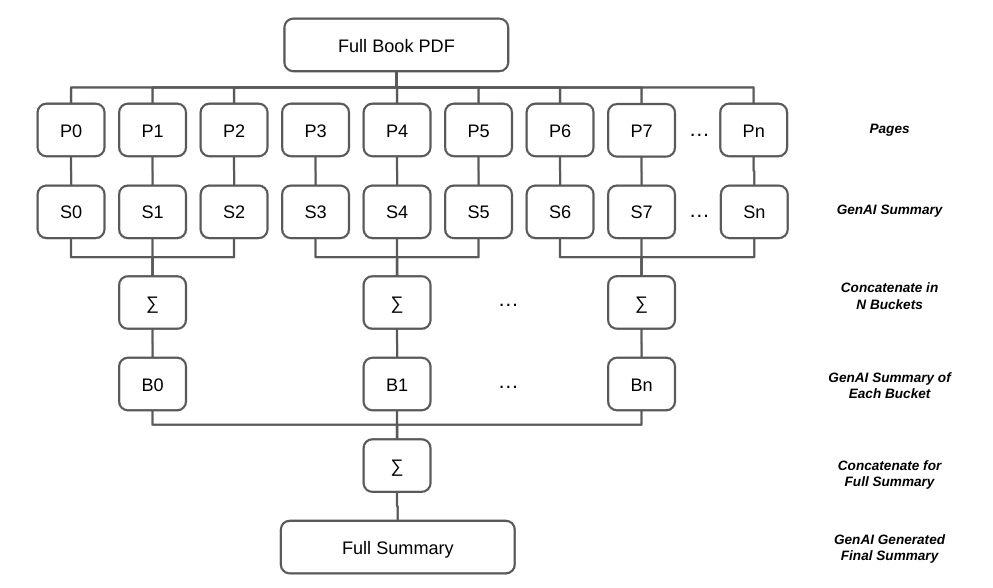

In [ ]:
initial_prompt_template = """
    As a finanical expert, write a concise summary of the following text delimited by triple backquotes. Include financial stats as well in the summary.

    ```{text}```

    CONCISE SUMMARY:
"""

first_reduce_prompt_template = """
    As a finanical expert, write a concise summary of the following text delimited by triple backquotes. Include financial stats as well in the summary.
    ```{text}```

    BULLET POINT SUMMARY:
"""

In [ ]:
#Bucket Building Logic
def divide_pages(n_pages, buckets):
  """
  Divides n_pages into buckets.

  Args:
    n_pages: The number of pages to divide.
    buckets: The number of buckets to divide the pages into.

  Returns:
    A list of tuples, where each tuple contains the start and end page number of a bucket.
  """
  bucket_list = []
  start_page = 1
  end_page = buckets
  while start_page < n_pages:
    bucket_list.append((start_page, min(end_page, n_pages)))
    start_page = end_page + 1
    end_page = start_page + buckets

  return bucket_list

In [ ]:
n_pages = len(pages) # this should be ideally greater than 50
element_in_buckets = 30 #this should not be more than 20/30 ; n_pages >> buckets # number of pages in each_bucket
bucket_list = divide_pages(n_pages, element_in_buckets)
print(bucket_list)

[(1, 30), (31, 61), (62, 92), (93, 123), (124, 154), (155, 179)]


### Step 1 - Map at Bucket Level

In [ ]:
bucket_summary_dict = {}
exclude_page_list = [1,2,3,20,30] # WHAT PAGES TO EXCLUDE IN THE PROCESS

for bucket_index, i_page in enumerate(bucket_list):  #for each bucket

  start, end = i_page
  bucket_summary_dict[bucket_index+1] = {}

  # if bucket_index in [0,1,2]:   #Debug Mode

  for page_number in range(start, end):
    # Inside Bucket - LOCAL MAP

    # Excluding pages
    if page_number not in exclude_page_list:

      # Extract the text from the page and remove any leading or trailing whitespace
      text = pages[page_number].extract_text().strip()

      # Create a prompt for the model using the extracted text and a prompt template
      prompt = initial_prompt_template.format(text=text)

      # Generate a summary using the model and the prompt
      summary = model_with_limit_and_backoff(prompt=prompt, max_output_tokens=1024).text

      # Append the summary to the list of summaries
      bucket_summary_dict[bucket_index+1][page_number] = summary

INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.3s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.3496602870178662 seconds after 1 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.9s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.9164830043516166 seconds after 2 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 1.0s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.971143287429773 seconds after 3 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 6.9s (ratelimit.exception.RateLimitException: too many calls)


Backing off 6.863184286434848 seconds after 4 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 1.9s (ratelimit.exception.RateLimitException: too many calls)


Backing off 1.8999014759395596 seconds after 5 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 19.2s (ratelimit.exception.RateLimitException: too many calls)


Backing off 19.248429963017482 seconds after 6 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.1s (ratelimit.exception.RateLimitException: too many calls)
INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.2s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.13913266327497276 seconds after 1 tries
Backing off 0.19344198711950678 seconds after 2 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 2.1s (ratelimit.exception.RateLimitException: too many calls)


Backing off 2.0964446658198272 seconds after 3 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 5.1s (ratelimit.exception.RateLimitException: too many calls)


Backing off 5.062021391510348 seconds after 4 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 14.0s (ratelimit.exception.RateLimitException: too many calls)


Backing off 13.97529231376658 seconds after 5 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 28.6s (ratelimit.exception.RateLimitException: too many calls)


Backing off 28.578845889550102 seconds after 6 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.9s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.861065038774311 seconds after 1 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.7s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.7250308398080672 seconds after 2 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 3.2s (ratelimit.exception.RateLimitException: too many calls)


Backing off 3.2422103925135968 seconds after 3 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 2.2s (ratelimit.exception.RateLimitException: too many calls)


Backing off 2.1554214669796687 seconds after 4 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 7.5s (ratelimit.exception.RateLimitException: too many calls)


Backing off 7.49254880907845 seconds after 5 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 28.8s (ratelimit.exception.RateLimitException: too many calls)


Backing off 28.846370367257904 seconds after 6 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.6s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.5772623023139375 seconds after 1 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.3s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.28147391888690887 seconds after 2 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 3.4s (ratelimit.exception.RateLimitException: too many calls)


Backing off 3.4425988488518375 seconds after 3 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 6.2s (ratelimit.exception.RateLimitException: too many calls)


Backing off 6.15678203943661 seconds after 4 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 10.2s (ratelimit.exception.RateLimitException: too many calls)


Backing off 10.184995203646192 seconds after 5 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 5.4s (ratelimit.exception.RateLimitException: too many calls)


Backing off 5.394079175436968 seconds after 6 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.5s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.4790414254730322 seconds after 1 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 1.5s (ratelimit.exception.RateLimitException: too many calls)


Backing off 1.5083226758895778 seconds after 2 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 3.2s (ratelimit.exception.RateLimitException: too many calls)


Backing off 3.21534611172289 seconds after 3 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.8s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.791037027970134 seconds after 4 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 5.3s (ratelimit.exception.RateLimitException: too many calls)


Backing off 5.317310042522758 seconds after 5 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 2.6s (ratelimit.exception.RateLimitException: too many calls)


Backing off 2.622312366469412 seconds after 6 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 58.2s (ratelimit.exception.RateLimitException: too many calls)


Backing off 58.247092389972536 seconds after 7 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.4s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.44634820967030964 seconds after 1 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 1.5s (ratelimit.exception.RateLimitException: too many calls)


Backing off 1.4802629536401508 seconds after 2 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 2.1s (ratelimit.exception.RateLimitException: too many calls)


Backing off 2.069203504536577 seconds after 3 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 1.2s (ratelimit.exception.RateLimitException: too many calls)


Backing off 1.1838211137801053 seconds after 4 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 5.6s (ratelimit.exception.RateLimitException: too many calls)


Backing off 5.551025929906734 seconds after 5 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 28.0s (ratelimit.exception.RateLimitException: too many calls)


Backing off 28.034839669941835 seconds after 6 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.4s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.3680507403941863 seconds after 1 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.5s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.504792445660327 seconds after 2 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.3s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.2536055514067739 seconds after 3 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 2.7s (ratelimit.exception.RateLimitException: too many calls)


Backing off 2.7439562365136663 seconds after 4 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 10.1s (ratelimit.exception.RateLimitException: too many calls)


Backing off 10.086583502096222 seconds after 5 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 1.5s (ratelimit.exception.RateLimitException: too many calls)


Backing off 1.5454686175643886 seconds after 6 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 40.9s (ratelimit.exception.RateLimitException: too many calls)


Backing off 40.85576038724582 seconds after 7 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 0.6s (ratelimit.exception.RateLimitException: too many calls)


Backing off 0.5839013445025182 seconds after 1 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 1.9s (ratelimit.exception.RateLimitException: too many calls)


Backing off 1.8810078462324702 seconds after 2 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 3.9s (ratelimit.exception.RateLimitException: too many calls)


Backing off 3.8872938847296816 seconds after 3 tries


INFO:backoff:Backing off model_with_limit_and_backoff(...) for 7.4s (ratelimit.exception.RateLimitException: too many calls)


Backing off 7.420590371373339 seconds after 4 tries


### Reduce at Bucket Level; Reduction/Bucket

In [ ]:
bucket_map_reduce_sumamry = {}
for key, value in bucket_summary_dict.items():
    concat_summary = "\n".join(value.values())
    # Create a prompt for the model using the concatenated text and a prompt template
    prompt = first_reduce_prompt_template.format(text=concat_summary)

    # Generate a summary using the model and the prompt
    final_summary = model_with_limit_and_backoff(prompt=prompt, max_output_tokens=1024).text
    bucket_map_reduce_sumamry[key] = final_summary

In [ ]:
pd.DataFrame.from_dict(bucket_map_reduce_sumamry, orient='index')

,0
1,"The Indian economy is resilient, supported by ..."
2,The Indian economy is recovering and is expect...
3,
4,"- The Indian banking system is stable, with st..."
5,"The Financial Stability Report June 2023, publ..."
6,The Financial Stability Report June 2023 inclu...


In [ ]:
print(bucket_map_reduce_sumamry[1])

The Indian economy is resilient, supported by strong macroeconomic fundamentals.
The Indian financial system is sound and resilient, with banks well-capitalised and all banks would be able to comply with the minimum capital requirements even under adverse stress scenarios.
The financial system is resilient, with risks from global spillovers remaining high. The Systemic Risk Survey showed that risk across most categories that contribute to domestic systemic risk have receded. Risk from global spillovers, however, remained in the ‘high’ risk category with more than half of the respondents expressing falling confidence in the stability of the global financial system. Tightening of global financial conditions, global growth slowdown and volatility in capital flows were cited as major risks. 94 per cent of the respondents expressed confidence in the Indian financial system with more than half of the respondents assessing improved domestic banking sector prospects over a one-year horizon.


### Reduction of All Bucket

In [ ]:
final_bullet_prompt_template = """
    Write a summary of the following text delimited by triple backquotes.
    Return your response in atleast ten bullet points which covers all the key points of the text.

    ```{text}```

    BULLET POINT SUMMARY:
"""

In [ ]:
#Final MapReduce
concat_summary =""
concat_summary = "\n".join(bucket_map_reduce_sumamry.values())
print(concat_summary)
# Create a prompt for the model using the concatenated text and a prompt template
prompt = final_bullet_prompt_template.format(text=concat_summary)

# Generate a summary using the model and the prompt
final_summary = model_with_limit_and_backoff(prompt=prompt, max_output_tokens=1024).text
print("\n Final summary:\n")
print(final_summary)

The Indian economy is resilient, supported by strong macroeconomic fundamentals.
The Indian financial system is sound and resilient, with banks well-capitalised and all banks would be able to comply with the minimum capital requirements even under adverse stress scenarios.
The financial system is resilient, with risks from global spillovers remaining high. The Systemic Risk Survey showed that risk across most categories that contribute to domestic systemic risk have receded. Risk from global spillovers, however, remained in the ‘high’ risk category with more than half of the respondents expressing falling confidence in the stability of the global financial system. Tightening of global financial conditions, global growth slowdown and volatility in capital flows were cited as major risks. 94 per cent of the respondents expressed confidence in the Indian financial system with more than half of the respondents assessing improved domestic banking sector prospects over a one-year horizon.
Th

In [ ]:
#Only select selected page (not all pages are releavnt all the time). Like Index, TOC last pages etc. *****
#What are the key points extracted for each page/chunk. Persist that in dictionary/json ****
#Final REDUCE OF ALL BUCKETS